In [1]:
import geopandas as gpd
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from astropy.convolution import convolve
from tile_stitcher import get_raster_from_tiles
from shapely.geometry import box, shape
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from skimage.measure import label as labeler
from skimage.measure import regionprops

In [2]:
out = Path('out')

In [3]:
df = gpd.read_file(out / 'metadata.geojson')
df.head()

,opera_id,start_time,polarization,url,track_number,local_path,geometry
0,OPERA_L2_RTC-S1_T078-165486-IW2_20231105T00482...,2023-11-05 00:48:29+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,out/78/OPERA_L2_RTC-S1_T078-165486-IW2_2023110...,"POLYGON ((-99.92892 16.73507, -99.06057 16.896..."
1,OPERA_L2_RTC-S1_T041-086893-IW1_20231102T12352...,2023-11-02 12:35:27+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,out/41/OPERA_L2_RTC-S1_T041-086893-IW1_2023110...,"POLYGON ((-99.50360 16.87667, -100.30172 17.02..."
2,OPERA_L2_RTC-S1_T078-165486-IW2_20231024T00482...,2023-10-24 00:48:29+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,out/78/OPERA_L2_RTC-S1_T078-165486-IW2_2023102...,"POLYGON ((-99.92881 16.73528, -99.88313 16.743..."
3,OPERA_L2_RTC-S1_T041-086893-IW1_20231021T12352...,2023-10-21 12:35:27+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,out/41/OPERA_L2_RTC-S1_T041-086893-IW1_2023102...,"POLYGON ((-99.50539 16.87704, -99.54850 16.885..."
4,OPERA_L2_RTC-S1_T078-165486-IW2_20231012T00482...,2023-10-12 00:48:28+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,out/78/OPERA_L2_RTC-S1_T078-165486-IW2_2023101...,"POLYGON ((-99.92546 16.73504, -99.87977 16.743..."


In [4]:
track_number = 78 # 41 or 78

df_by_track = df[df.track_number == track_number].reset_index(drop=True)
df_by_track = df_by_track.sort_values(by='opera_id')
df_by_track.shape

(6, 7)

In [5]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        p = ds.profile
        X = ds.read(1)
    m = np.nanpercentile(X, 1)
    M = np.nanpercentile(X, 99)
    X = np.clip(X, m, M)
    return X, p

def get_4326_bounds(path) -> tuple:
    # https://gis.stackexchange.com/a/414528
    with rasterio.open(path) as ds:
        bounds = ds.bounds
        crs = ds.crs

    geojson_dict = rasterio.warp.transform_geom(crs,
                                                CRS.from_epsg(4326),
                                                box(*bounds))

    return shape(geojson_dict).bounds

arrays_vv, profiles_vv = zip(*list(map(open_one, df_by_track[df_by_track.polarization == 'VV'].local_path)))
arrays_vh, profiles_vh = zip(*list(map(open_one, df_by_track[df_by_track.polarization == 'VH'].local_path)))

factor = 5
arrays_ra = [np.clip(vh / vv, 1./factor, factor) / factor for (vv, vh) in zip(arrays_vv, arrays_vh)]

mask = np.isnan(arrays_vh[0])

In [6]:
path_0 = df_by_track.local_path.tolist()[0]
extent = get_4326_bounds(path_0)
extent

(-100.01684977804626,
 16.692468700823014,
 -99.04943068118348,
 17.126682101564025)

In [7]:
X_water, p_water = get_raster_from_tiles(extent, tile_shortname='esa_world_cover_2021')

In [8]:
X_water_r, _ = reproject_arr_to_match_profile(X_water, p_water, profiles_vv[0], resampling='nearest')
X_water_r = X_water_r[0, ...]

In [9]:
M = (X_water_r ==80)
def masker(X):
    X_c = X.copy()
    X_c[M] = np.nan
    return X_c

arrays_vv_masked = [masker(X) for X in arrays_vv]
arrays_vh_masked = [masker(X) for X in arrays_vh]

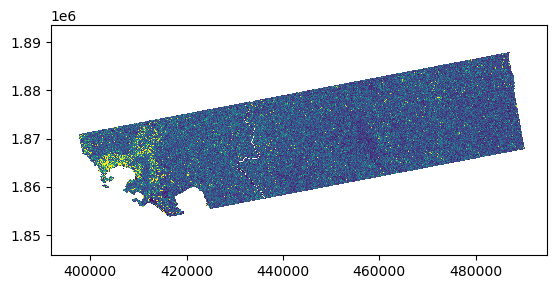

<Axes: >

In [10]:
ind = 0

show(arrays_vv_masked[ind], transform=profiles_vv[0]['transform'], interpolation='none')

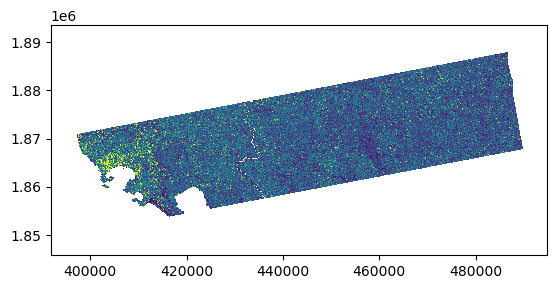

<Axes: >

In [11]:
ind = -1

show(arrays_vv_masked[ind], transform=profiles_vv[0]['transform'], interpolation='none')

This is the [source](https://www.researchgate.net/publication/229390532_How_to_Compare_Noisy_Patches_Patch_Similarity_Beyond_Gaussian_Noise) of this simple change statistic and general approach.

In [14]:
PATCH_SIZE = 5
def get_change_statistic(img_0, img_1, patch_size=PATCH_SIZE, mask=None):
    X_0, X_1 = img_0, img_1
    glr = np.log(X_0 * X_1 / (X_0 + X_1)**2)

    if mask is not None:
        glr[mask] = np.nan
    
    kernel = np.ones((patch_size, patch_size))
    change_statistic = convolve(glr,
                                kernel,
                                boundary='extend',
                                nan_treatment='interpolate',
                                normalize_kernel=True,
                                preserve_nan=True)
       
    return change_statistic

In [15]:
change_statistic = get_change_statistic(arrays_vh_masked[1], 
                                        arrays_vh_masked[2]
                                        )

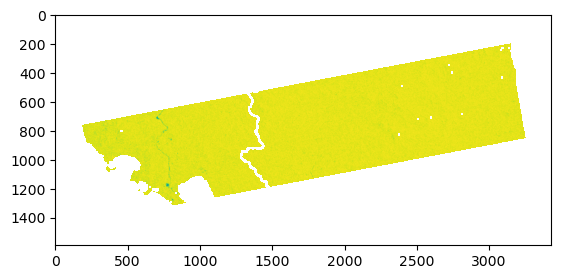

In [16]:
plt.imshow(change_statistic)

In [17]:
def get_contiguous_areas_of_class_with_maximum_size(X_data: np.ndarray,
                                                    class_label: int | list[int],
                                                    max_contiguous_pixel_area: int) -> np.ndarray:

    if isinstance(class_label, int):
        class_labels = [class_label]
    elif isinstance(class_label, list):
        class_labels = class_label
    else:
        raise TypeError('Class_label must be int or list of ints')

    if X_data.dtype not in ['uint8', 'int32', 'int64']:
        raise ValueError('Please recast array as integer array')

    X_binary = np.isin(X_data, class_labels).astype(np.uint8)
    label_arr = labeler(X_binary,
                        connectivity=1,
                        background=0)
    props = regionprops(label_arr)

    labels_to_exclude = [(k+1) for (k, prop) in enumerate(props) if prop.area <= max_contiguous_pixel_area]
    size_mask = np.isin(label_arr, labels_to_exclude)

    return size_mask

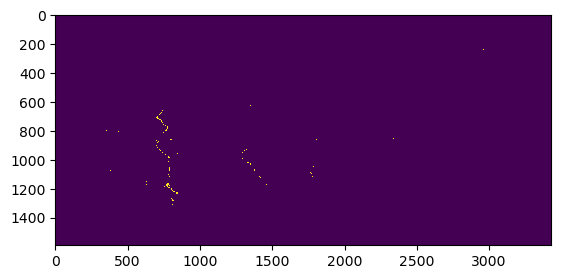

In [24]:
PERCENTILE = 1
# Percentile indicates how much change we expect (upper bound)
T = np.nanpercentile(change_statistic, PERCENTILE)

data_mask = ~np.isnan(change_statistic)
C = np.zeros(change_statistic.shape, dtype=np.uint8)
C[data_mask] = (change_statistic[data_mask] < T).astype(np.uint8)

# Filter out areas that have decrease in backscatter
C[arrays_vh_masked[1] < arrays_vh_masked[2]] = 0

# only consider change with at least 10 pixels in signle area
C_size_f = C.copy()
size_mask = get_contiguous_areas_of_class_with_maximum_size(C, 1, 10)
C_size_f[size_mask] = 0

plt.imshow(C_size_f, interpolation='none')

In [25]:
change_dir = Path('out') / f'{track_number}' / 'change'
change_dir.mkdir(exist_ok=True, parents=True)

In [26]:
p_change = profiles_vh[0].copy()
p_change['dtype'] = 'uint8'
p_change['nodata'] = None

with rasterio.open(change_dir / 'change.tif', 'w', **p_change) as ds:
    ds.write(C_size_f, 1)